In [731]:
import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import mne
from mne import Epochs, pick_types, find_events
from mne.filter import filter_data
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_gdf
from mne.decoding import CSP
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from EEGModels import EEGNet
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# %matplotlib tk


'''
Parameters:
'''
tmin = 0.3
tmax = 3

In [732]:
object_names = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10']
object_names = ['P05']
runMove = [3, 4, 5, 6, 7, 10, 11, 12, 13]
files = []
for name in object_names:
    for i in runMove:
        files.append(read_raw_gdf(f'..\\{name}\\{name} Run {i}.gdf', stim_channel=None, eog=[61,62,63], preload=True))

Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P05\P05 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...
Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P05\P05 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P05\P05 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76031  =      0.000 ...   296.996 secs...
Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P05\P05 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creatin

C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

In [733]:
print(len(files))

9


In [734]:
eventDescription_offline_paradigm = {
    #'768': "trial start",
    #'785': "beep",
    #'786': "fixation cross",
    '776': "supinationclass cue",
    '777': "pronationclass cue",
    '779': "hand openclass cue",
    '925': "palmar graspclass cue",
    '926': "ateral graspclass cue",
}
# narrow it down to two
eventDescription_offline_paradigm = {
   '779': "hand openclass cue",
   '925': "palmar graspclass cue",
}

In [735]:
# events = [number of events, position, event code, channel, duration]
# file_P01_Run3._raw_extras[0]['events']
event_id = {}
epochs_list = []
for file in files:
    # band pass filter
    # file.filter(0.1, 100, method='fir')
    event, _ = mne.events_from_annotations(file)
    # build event id and filter 1-7 id

    contains_both = 0
    for i in _: #handle event_id
        if i not in eventDescription_offline_paradigm:
            continue
        contains_both += 1
        event_id[eventDescription_offline_paradigm[i]] = _[i]


    print(f'event id: {event_id}')
    if contains_both == len(eventDescription_offline_paradigm):
        epochs = mne.Epochs(file, event, event_id, tmin=tmin, tmax=tmax, baseline=None, event_repeated = 'merge', preload=True)
        epochs_list.append(epochs)

result_epochs = mne.concatenate_epochs(epochs_list)

Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
event id: {'hand openclass cue': 11, 'palmar graspclass cue': 14}
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Loading data for 16 events and 692 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
event id: {'hand openclass cue': 11, 'palmar graspclass cue': 14}
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Loading data for 16 events and 692 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']

Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
[[21023     0    11]
 [22592     0    11]
 [25864     0    11]
 [40223     0    11]
 [41878     0    11]
 [45467     0    11]
 [49034     0    11]
 [54248     0    11]]
[[ 3072     0    14]
 [ 8805     0    14]
 [13765     0    14]
 [19246     0    14]
 [24186     0    14]
 [27649     0    14]
 [56253     0    14]
 [72591     0    14]]
Effective window size : 8.000 (s)


<ipython-input-736-f94208927d6a>:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  file.plot_psd(fmax=30)


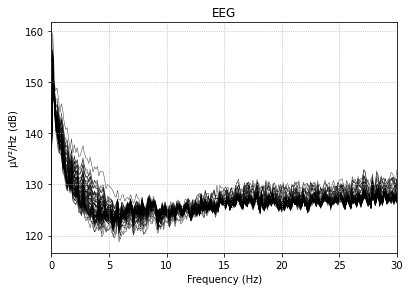

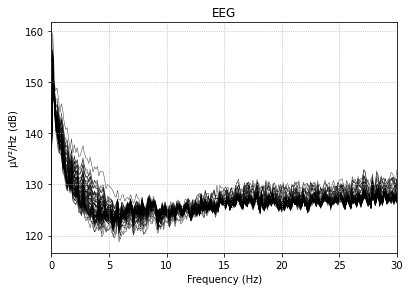

In [736]:
# plotting
file = files[0]
event, _ = mne.events_from_annotations(file)
event1 = np.array(list(filter(lambda x: x[2] == 11, event)))
event2 = np.array(list(filter(lambda x: x[2] == 14, event)))
print(event1)
print(event2)
file.plot_psd(fmax=30)

In [737]:
print(len(set(event_id)))
#9, 10, 0
print(result_epochs.events)

2
[[  3072      0     14]
 [  8805      0     14]
 [ 13765      0     14]
 [ 19246      0     14]
 [ 21023      0     11]
 [ 22592      0     11]
 [ 24186      0     14]
 [ 25864      0     11]
 [ 27649      0     14]
 [ 40223      0     11]
 [ 41878      0     11]
 [ 45467      0     11]
 [ 49034      0     11]
 [ 54248      0     11]
 [ 56253      0     14]
 [ 72591      0     14]
 [ 81022      0     14]
 [ 93521      0     14]
 [100688      0     14]
 [103994      0     14]
 [109051      0     11]
 [112595      0     14]
 [121406      0     11]
 [123334      0     11]
 [125207      0     14]
 [126937      0     14]
 [128537      0     11]
 [133664      0     11]
 [137480      0     11]
 [139208      0     14]
 [145010      0     11]
 [148579      0     11]
 [158543      0     14]
 [164527      0     14]
 [169568      0     11]
 [173272      0     14]
 [174881      0     11]
 [176621      0     14]
 [180453      0     11]
 [185453      0     14]
 [188967      0     11]
 [190656      

In [738]:
# 0: not supinationclass or pronationclass cue
labels = result_epochs.events[:,-1]
# labels = np.array(list(map(lambda x:  0 if (not x == 9) else x, labels)))
print(labels)

# format: trials, channels, samples
X = result_epochs.get_data()
y = labels

kernels, chans, samples = 1, X.shape[1], X.shape[2]

[14 14 14 14 11 11 14 11 14 11 11 11 11 11 14 14 14 14 14 14 11 14 11 11
 14 14 11 11 11 14 11 11 14 14 11 14 11 14 11 14 11 14 11 11 11 11 14 14
 14 11 14 11 14 14 14 11 11 11 14 14 14 11 11 11 14 14 14 11 11 14 14 11
 11 14 11 14 14 11 11 11 14 11 14 11 14 14 11 14 14 14 14 11 11 11 11 11
 14 11 11 14 14 11 14 14 14 11 11 14 11 11 11 14 14 14 11 11 14 11 11 14
 14 11 14 11 11 14 11 14 11 14 11 14 14 11 14 11 11 14 14 14 14 11 11 11]


In [739]:
print(np.argmax(result_epochs.get_data()[0]))
print(np.argmax(result_epochs.get_data()[1]))
print(np.argmax(result_epochs.get_data()[2]))



22599
4715
13804


In [740]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(Y_train)

[11 11 11 14 14 11 11 11 11 14 11 14 11 11 14 14 14 11 14 14 14 14 11 11
 11 14 11 14 11 14 11 11 14 11 11 14 11 11 14 14 11 11 14 14 11 11 11 14
 14 11 11 14 14 11 14 14 14 14 14 14 11 11 11 11 11 11 14 14 14 14 14 11
 14 11 14 14 14 14 11 11 14 14 14 14 14 14 11 14 14 14 14 11 11 11 11 11
 11 14 11 14]


In [741]:
# Label Encode it first
encoder = OneHotEncoder()
encoder.fit([[x] for x in Y_train])
Y_train = encoder.transform([[x] for x in Y_train]).toarray()
Y_test = encoder.transform([[x] for x in Y_test]).toarray()

# Convert label to one-hot encodings
# Y_train = np_utils.to_categorical(Y_train)
# Y_validate = np_utils.to_categorical(Y_validate)
# Y_test = np_utils.to_categorical(Y_test)

#convert to (trials, kernels, channels, samples) format.
# contains 64 channels and 257 time-points. Set the number of kernels to 1.
X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (100, 1, 64, 692)
100 train samples
44 test samples


In [742]:
print(Y_train)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [743]:
# testing gpu
from tensorflow.python.client import device_lib
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
gpus = tf.config.experimental.list_physical_devices('GPU')
for physical_device in gpus:
    tf.config.experimental.set_memory_growth(physical_device, True)
# change the memory fraction as you want...import tensorflow as tf
# if gpus:
#     # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)
print(gpus)

['/device:CPU:0', '/device:XLA_CPU:0', '/device:GPU:0', '/device:XLA_GPU:0']
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [744]:
classes_num = len(eventDescription_offline_paradigm)
# configure the EEGNet-8,2,16 model with kernel length of 257 samples (other
# model configurations may do better, but this is a good starting point)
# class num is one
model = EEGNet(nb_classes = classes_num, Chans = chans, Samples = samples,
               dropoutRate = 0.8, kernLength = 128, F1 = 8, D = 2, F2 = 16)
model.summary()

Model: "functional_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 1, 64, 692)]      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 64, 692)        1024      
_________________________________________________________________
batch_normalization_105 (Bat (None, 8, 64, 692)        32        
_________________________________________________________________
depthwise_conv2d_35 (Depthwi (None, 16, 1, 692)        1024      
_________________________________________________________________
batch_normalization_106 (Bat (None, 16, 1, 692)        64        
_________________________________________________________________
activation_70 (Activation)   (None, 16, 1, 692)        0         
_________________________________________________________________
average_pooling2d_70 (Averag (None, 16, 1, 173)      

In [745]:
# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='.\\checkpoint.h5', verbose=1,
                               save_best_only=True)


In [746]:
# add callback
losses = []
accs = []
class LossAndAccRecord(Callback):
    def on_batch_end(self, batch, logs=None):
        losses.append(logs["loss"])
        accs.append(logs["accuracy"])


    def on_epoch_end(self, epoch, logs=None):
        pass


In [747]:
# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
# unused
class_weights = {0:1, 1:1, 2:1, 3:1}
with tf.device('/device:GPU:0'):
    fittedModel = model.fit(X_train, Y_train, batch_size = 20, epochs = 40,
                        verbose = 1, callbacks=[checkpointer, LossAndAccRecord()])

Epoch 1/40
5/5 [==============================] - 0s 13ms/step - loss: 0.7043 - accuracy: 0.5400
Epoch 2/40
5/5 [==============================] - 0s 12ms/step - loss: 0.6411 - accuracy: 0.6600
Epoch 3/40
5/5 [==============================] - 0s 12ms/step - loss: 0.6562 - accuracy: 0.6300
Epoch 4/40
5/5 [==============================] - 0s 13ms/step - loss: 0.6475 - accuracy: 0.6300
Epoch 5/40
5/5 [==============================] - 0s 11ms/step - loss: 0.6211 - accuracy: 0.6600
Epoch 6/40
5/5 [==============================] - 0s 12ms/step - loss: 0.5831 - accuracy: 0.7100
Epoch 7/40
5/5 [==============================] - 0s 12ms/step - loss: 0.5771 - accuracy: 0.7100
Epoch 8/40
5/5 [==============================] - 0s 12ms/step - loss: 0.5454 - accuracy: 0.7600
Epoch 9/40
5/5 [==============================] - 0s 11ms/step - loss: 0.5404 - accuracy: 0.7500
Epoch 10/40
5/5 [==============================] - 0s 11ms/step - loss: 0.5285 - accuracy: 0.7600
Epoch 11/40
5/5 [============

In [748]:
# load optimal weights
# model.load_weights('./checkpoint.h5')

In [749]:
###############################################################################
# make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
print(probs)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %.4f " % (acc))

[[0.7848322  0.21516788]
 [0.4622566  0.53774333]
 [0.16295695 0.8370431 ]
 [0.62040293 0.37959713]
 [0.24747404 0.7525259 ]
 [0.4759159  0.5240841 ]
 [0.47766912 0.5223309 ]
 [0.6814186  0.31858137]
 [0.56335783 0.43664214]
 [0.34381306 0.6561869 ]
 [0.75406444 0.2459356 ]
 [0.73927116 0.26072887]
 [0.6210171  0.37898287]
 [0.5884671  0.4115329 ]
 [0.2989942  0.70100576]
 [0.66693074 0.3330693 ]
 [0.85347074 0.14652926]
 [0.70599777 0.29400226]
 [0.6176284  0.3823716 ]
 [0.36067244 0.6393276 ]
 [0.65029144 0.34970856]
 [0.3974576  0.60254234]
 [0.90887934 0.09112068]
 [0.43373716 0.56626284]
 [0.8415356  0.15846442]
 [0.7255638  0.27443624]
 [0.8005939  0.19940609]
 [0.65494174 0.3450583 ]
 [0.8180809  0.18191907]
 [0.83313096 0.16686907]
 [0.7560705  0.24392956]
 [0.48325983 0.51674014]
 [0.71952695 0.28047308]
 [0.32861674 0.67138326]
 [0.502462   0.4975379 ]
 [0.8580576  0.14194241]
 [0.26083595 0.73916405]
 [0.6302226  0.36977735]
 [0.8113653  0.18863471]
 [0.5206038  0.47939622]


In [750]:
confusion_matrix(Y_test.argmax(axis=-1), preds)

array([[21,  3],
       [ 7, 13]], dtype=int64)

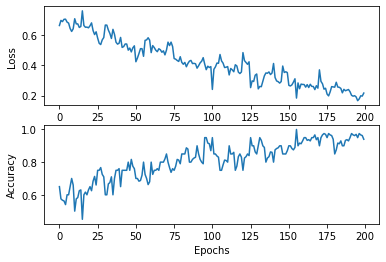

In [751]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2)
ax[0].plot(losses)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[1].plot(accs)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
plt.show()